In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

## Encoding and Decoding Functions

In [154]:
def audio_from_wav(filename):
    fs, data = wavfile.read(filename)
    audio = (data[:,0] + data[:,1]) // 2
    data[:,0] = audio
    data[:,1] = audio
    filename = filename.split('.')[0] + '_mono.wav'
    wavfile.write(filename, fs, data)
    return fs, audio

def audio_to_wav(audio, filename, fs, N_original):
    data = np.zeros((N_original, 2)).astype(np.int16)
    data[:,0] = audio[0:N_original]
    data[:,1] = audio[0:N_original]
    wavfile.write(filename, fs, data)

def pad_audio(audio, fs, df):
    N = len(audio)
    N_min = fs/df
    N_req = int((N // N_min + 1) * N_min - N)
    pad = np.linspace(0, 0, N_req)
    audio = np.concatenate((audio, pad))
    return audio

def remove_low_frequencies(audio, fs, f_max):
    audio_fft = np.fft.rfft(audio)
    audio_fft[0:len(audio)*f_max//fs] = 0
    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def add_data(audio, data, ampl, fs, df, f_min):
    f_min = max(f_min, df)
    
    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            audio_fft[f] = ampl * data[f_d]
            f_d += 1
            if f_d == len(f_data):
                break

    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def recover_data(audio, data_ampl, data_len, fs, df, f_min):
    data = np.zeros(data_len)

    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            if (audio_fft[f] > data_ampl/2):
                data[f_d] = 1
            f_d += 1
            if f_d == len(f_data):
                break
    return data

## Encryption Functions

## Helper Functions

In [155]:
def plot_fft(audio, fs, f_max = 250):
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)
    plt.figure()
    plt.plot(f_full, np.abs(audio_fft))
    plt.xlim([0, f_max])
    plt.ylim([0, 1.5e7])
    plt.title('Song fft')

[0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.]


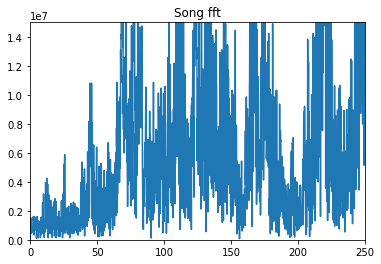

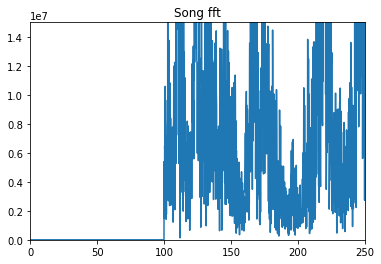

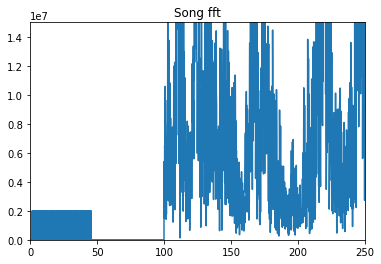

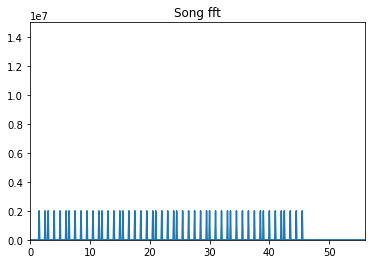

In [156]:
DELTA_FREQUENCIES = 0.5 # Hz
LOWEST_FREQUENCY = 1 # Hz
data = [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]

fs, audio = audio_from_wav('AudioFiles/bumblebee_small.wav')
N_original = len(audio)
plot_fft(audio, fs)

audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
audio = remove_low_frequencies(audio, fs, 100)
plot_fft(audio, fs)

audio = add_data(audio, data, 0.2e7, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
plot_fft(audio, fs)
plot_fft(audio, fs, len(data)*DELTA_FREQUENCIES + LOWEST_FREQUENCY + 10)
audio_to_wav(audio, 'AudioFiles/bumblebee_small_with_data.wav', fs, N_original)

data_r = recover_data(audio, 0.2e7, len(data), fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
print(data_r)
